# Title

This notebook uses 

#### Findings

The accuracy of NER on the test encoding was very bad. NER, I think, really struggles with the diary format. Building and training a custom NER model might improve the results, though.

#### Sources

Kumar, Ajitesh, "[Accuracy, Precision, Recall & F1-Score—Python Examples](https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/)," <i>Data Analytics</i>, Accessed October 20, 2020.

In [1]:
# Import necessary libraries.
import re, nltk, warnings, glob, csv, sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from itertools import chain
from nltk import word_tokenize, pos_tag, ne_chunk, Tree
from fuzzywuzzy import fuzz, process
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore") # specify ignore: , DeprecationWarning

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/SemanticData/"

## Read in and Parse Data

Based on previous notebook: JQA_XML-Parser. Modified to return content of "persName" and "placeName" elements.

In [2]:
%%time

# Gather all .xml files using glob.
list_of_files = glob.glob(abs_dir + "Data/TestEncoding/TrainingData/*.xml")

# Declare regex to simplify file paths below
regex = re.compile(r'.*/TestEncoding/(.*)')

# Get plain text of every element (designated by first argument).
def get_textContent(ancestor, xpath_as_string, namespace):
    text_list = []
    for elem in ancestor.findall(xpath_as_string, namespace):
        text = ''.join(ET.tostring(elem, encoding='unicode', method='text'))

#         Add text (cleaned of additional whitespace) to text_list.
        text_list.append(re.sub(r'\s+', ' ', text))

#     Return concetanate text list.
    return ' '.join(text_list)

# Create dataframe to store results.
entities = pd.DataFrame(columns = ['file', 'entry', 'text', 'element', 'entity'])

#     Loop through each file within a directory.
for file in list_of_files:
    tree = ET.parse(file)
    root = tree.getroot()
    namespace = re.match(r"{(.*)}", str(root.tag))
    ns = {"ns":namespace.group(1)}
    reFile = str(regex.match(file).group(1))

    for eachDoc in root.findall('.//ns:div/[@type="entry"]', ns):
        entry = eachDoc.get('{http://www.w3.org/XML/1998/namespace}id')
        text = get_textContent(eachDoc, './ns:div/[@type="docbody"]/ns:p', ns)

#         Duplicate for-loops: one gathers <persName> content & the other <placeName>
        for elem in eachDoc.findall('.//ns:p//ns:persName', ns):
            name = elem.text
            try:
                entity = re.sub(r'\s+', ' ', name)
            except TypeError:
                entity = name
            
            entities = entities.append({'file':reFile,
                            'entry':entry,
                            'element':re.sub(r'.*}(.*)', '\\1', elem.tag),
                            'entity':entity,
                            'text':text},
                           ignore_index = True)
        
        
        for elem in eachDoc.findall('.//ns:p//ns:placeName', ns):
            place = elem.text
            try:
                entity = re.sub(r'\s+', ' ', place)
            except TypeError:
                entity = place        
            
            
            entities = entities.append({'file':reFile,
                                        'entry':entry,
                                        'element':re.sub(r'.*}(.*)', '\\1', elem.tag),
                                        'entity':entity,
                                        'text':text},
                                       ignore_index = True)
                
entities.head()

CPU times: user 278 ms, sys: 3.89 ms, total: 282 ms
Wall time: 283 ms


,file,entry,text,element,entity
0,TrainingData/TrainCopy_JQADiaries-v23-1821-05-...,jqadiaries-v23-1821-05-01,1 V:15. Tuesday. W. A. Schoolfield at the Offi...,persName,W. A. Schoolfield
1,TrainingData/TrainCopy_JQADiaries-v23-1821-05-...,jqadiaries-v23-1821-05-02,2. VI: Mrs. Adams unwell. Despatches to A. Gal...,persName,Adams
2,TrainingData/TrainCopy_JQADiaries-v23-1821-05-...,jqadiaries-v23-1821-05-02,2. VI: Mrs. Adams unwell. Despatches to A. Gal...,persName,A. Gallatin
3,TrainingData/TrainCopy_JQADiaries-v23-1821-05-...,jqadiaries-v23-1821-05-02,2. VI: Mrs. Adams unwell. Despatches to A. Gal...,persName,La Forêt
4,TrainingData/TrainCopy_JQADiaries-v23-1821-05-...,jqadiaries-v23-1821-05-02,2. VI: Mrs. Adams unwell. Despatches to A. Gal...,persName,Canning


## Named-Entity Recognition

The NER process below will return a list of people and locations from the plain text of JQA's diary entries. The list of entities will then be attached to each element, creating duplicate lists. The text content of each element, then, matches with the most likely entity within that list, which essentially de-duplicates the list except in situations where there are repeated tag content. The final step determines if the 'best' match between element content and recognized entity is accurate (enough) to be considered a 'likely match.'

In [3]:
%%time

# Declare Function to Return Named Entity Chunk as String
def get_continuous_chunks(text, label_list): # changed 'list' to 'label_list'
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() in label_list: # changed '== label' to 'in label_list'
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append((named_entity, subtree.label())) # changed: , subtree.label()
                current_chunk = []
        else:
            continue

    return continuous_chunk

# Apply function to text column and create a new 'ner_people' column in the dataframe.
entities['ner_entities'] = entities \
    .apply(lambda row: get_continuous_chunks(row['text'], ['PERSON', 'LOCATION']), axis = 1) 

# Remove 'text' & 'file' columns.
entities = entities[['entry', 'element', 'entity', 'ner_entities']]

# Unnest 'ner_entities'
entities = entities.explode('ner_entities')

# Un-tuple 'ner_entities'.
entities[['ner_entity', 'ner_label']] = pd.DataFrame(entities['ner_entities'].values.tolist(),
                                                     index = entities.index)


# Apply fuzzy matching function to encoded entities dataframe row by row.
entities['confidence'] = entities \
    .apply(lambda row: fuzz.token_sort_ratio(row['entity'], row['ner_entity']),
           axis = 1)

# Define function to return the dataframe row with the highest value in a group.
def grp_func(group, column):
    return group.loc[group[column] == group[column].max()]


# Select ner_match with highest confidence score for each entity in each entry.
entities = entities.groupby(['entry', 'entity'], as_index = False) \
    .apply(grp_func, 'confidence').reset_index(drop = True)


# The following function returns results with some fuzzy arguments (.ratio) but not others.
# Define function that assigns category to confidence score.
def assign_to_batch(row):
    if row['confidence'] >= 65:
        val = 'Possible_Match'
    else:
        val = 'Unlikely_Match'
    return val

# Apply function to datframe.
entities['match_quality'] = entities.apply(lambda row: assign_to_batch(row), axis = 1)

entities.head()

CPU times: user 937 ms, sys: 41.3 ms, total: 978 ms
Wall time: 995 ms


,entry,element,entity,ner_entities,ner_entity,ner_label,confidence,match_quality
0,jqadiaries-v23-1821-05-01,persName,W. A. Schoolfield,"(Slaves, PERSON)",Slaves,PERSON,29,Unlikely_Match
1,jqadiaries-v23-1821-05-02,persName,A. Gallatin,"(La Forêt, PERSON)",La Forêt,PERSON,35,Unlikely_Match
2,jqadiaries-v23-1821-05-02,persName,Adams,"(Adams, PERSON)",Adams,PERSON,100,Possible_Match
3,jqadiaries-v23-1821-05-02,persName,Canning,"(Adams, PERSON)",Adams,PERSON,17,Unlikely_Match
4,jqadiaries-v23-1821-05-02,persName,La Forêt,"(La Forêt, PERSON)",La Forêt,PERSON,100,Possible_Match


           result  match_quality
0  Unlikely_Match       0.634921
1  Possible_Match       0.365079 

CPU times: user 69.3 ms, sys: 7.31 ms, total: 76.6 ms
Wall time: 82.9 ms


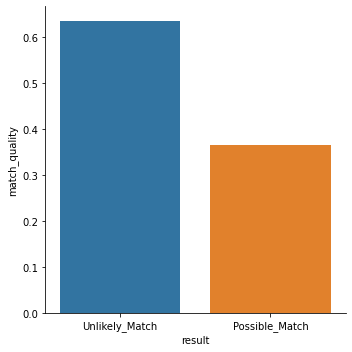

In [4]:
%%time

# Return a ratio of results.
counts = entities['match_quality'].value_counts(normalize= True) \
    .reset_index() \
    .rename(columns = {'index':'result'})

print (counts, '\n')

# Plot results.
g = sns.catplot(
    data = counts, kind = 'bar',
    x = 'result', y = 'match_quality'
)

In [5]:
%%time

# What percentage of these are found entities, though?
entities

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


,entry,element,entity,ner_entities,ner_entity,ner_label,confidence,match_quality
0,jqadiaries-v23-1821-05-01,persName,W. A. Schoolfield,"(Slaves, PERSON)",Slaves,PERSON,29,Unlikely_Match
1,jqadiaries-v23-1821-05-02,persName,A. Gallatin,"(La Forêt, PERSON)",La Forêt,PERSON,35,Unlikely_Match
2,jqadiaries-v23-1821-05-02,persName,Adams,"(Adams, PERSON)",Adams,PERSON,100,Possible_Match
3,jqadiaries-v23-1821-05-02,persName,Canning,"(Adams, PERSON)",Adams,PERSON,17,Unlikely_Match
4,jqadiaries-v23-1821-05-02,persName,La Forêt,"(La Forêt, PERSON)",La Forêt,PERSON,100,Possible_Match
...,...,...,...,...,...,...,...,...
121,jqadiaries-v23-1821-05-31,persName,Canning’s,"(Josiah Meigs, PERSON)",Josiah Meigs,PERSON,38,Unlikely_Match
122,jqadiaries-v23-1821-05-31,persName,Josiah Meigs,"(Josiah Meigs, PERSON)",Josiah Meigs,PERSON,100,Possible_Match
123,jqadiaries-v23-1821-05-31,persName,Omaley,"(Omaley, PERSON)",Omaley,PERSON,100,Possible_Match
124,jqadiaries-v23-1821-05-31,persName,Tazewell,"(Fellows, PERSON)",Fellows,PERSON,40,Unlikely_Match


## Accuracy

Accuracy measures how many NER results match the encoding of place- and persNames. 

1. Precision Score 
> Model precision score represents the model’s ability to correctly predict the positives out of all the positive prediction it made. Precision score is a useful measure of success of prediction when the classes are very imbalanced. Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

2. Recall Score
> Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures as to how many predictions made by models are actually positive out of all positive predictions made. Recall score is a useful measure of success of prediction when the classes are very imbalanced.  Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

3. Accuracy Score
> Model accuracy score represents the model’s ability to correctly predict both the positives and negatives out of all the predictions. Mathematically, it represents the ratio of sum of true positive and true negatives out of all the predictions.

4. F1-Score
>Model F1 score represents the model score as a function of precision and recall score. This is useful measure of the model in the scenarios where one tries to optimize either of precision or recall score and as a result, the model performance suffers. The following represents the aspects relating to issues with optimizing either precision or recall score:

    * Optimizing for recall helps with minimizing the chance of not detecting a malignant cancer. However, this comes at the cost of predicting malignant cancer in patients although the patients are healthy (a high number of FP).

    * Optimize for precision helps with correctness if the patient has a malignant cancer. However, this comes at the cost of missing malignant cancer more frequently (a high number of FN).

#### Entity Accuracy

In [6]:
%%time

# Create list of values in columns.
# 'entity_l' is treated as the test while 'nerEnt_l' works as the predictions.
entity_l = entities['entity'].values.tolist()
nerEnt_l = entities['ner_entity'].values.tolist()


print('Precision: %.3f' % precision_score(entity_l, nerEnt_l, average = 'macro'))
print('Recall: %.3f' % recall_score(entity_l, nerEnt_l, average = 'macro'))
print('Accuracy: %.3f' % accuracy_score(entity_l, nerEnt_l))
print('F1 Score: %.3f' % f1_score(entity_l, nerEnt_l, average = 'macro'), '\n')

Precision: 0.178
Recall: 0.219
Accuracy: 0.270
F1 Score: 0.182 

CPU times: user 11.4 ms, sys: 3.38 ms, total: 14.7 ms
Wall time: 12.9 ms


#### Label Accuracy

In [7]:
%%time

# Create label map to change column values
label_d = {'PERSON':'persName', 'LOCATION':'placeName'}
entities = entities.replace({'ner_label':label_d}).dropna() # dropna(): lurking 'None' value

# Create list of values in columns.
elem_l = entities['element'].values.tolist()
label_l = entities['ner_label'].values.tolist()

print('Precision: %.3f' % precision_score(elem_l, label_l, average = 'macro'))
print('Recall: %.3f' % recall_score(elem_l, label_l, average = 'macro'))
print('Accuracy: %.3f' % accuracy_score(elem_l, label_l))
print('F1 Score: %.3f' % f1_score(elem_l, label_l, average = 'macro'), '\n')

Precision: 0.467
Recall: 0.500
Accuracy: 0.933
F1 Score: 0.483 

CPU times: user 12.1 ms, sys: 3.78 ms, total: 15.9 ms
Wall time: 13.3 ms
